In [79]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
import saif.scinet.model as scinet
plt.style.use('ggplot')

%matplotlib inline

In [80]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [81]:
import pandas as pd
# seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
# pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

seismic_original = pd.read_csv("seismic.csv",index_col=0)
pressure_original = pd.read_csv("pressure.csv",index_col=0)

# seismic = seismic.drop(columns=['kmeans'])

seismic = pd.read_csv("temporal_datasets_decatur_illinois_seismic_new.csv",index_col=None)
pressure = pd.read_csv("temporal_datasets_decatur_illinois_pressure_new.csv",index_col=None)

pressure["epoch"] = pressure["epoch"]



In [82]:
features_original, target_vals_original = daily_seismic_and_interpolated_pressure(seismic_original, pressure_original)


In [83]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)


In [84]:
input_len = 16 # try wider window power of 2
horizon = 7 # prediction window

# Trying out different input_len and horizon
# input_len = 32
# horizon = 14

In [85]:
features = features[['pressure','dpdt','seismic']]

In [86]:
features

,pressure,dpdt,seismic
0,8.599065e+06,0.017439,1.0
1,8.601838e+06,0.018007,1.0
2,8.604612e+06,0.018575,2.0
3,8.607385e+06,0.019143,2.0
4,8.610158e+06,0.019711,2.0
...,...,...,...
1106,8.652984e+06,-0.029754,4886.0
1107,8.649775e+06,-0.030196,4886.0
1108,8.646565e+06,-0.030638,4889.0
1109,8.643355e+06,-0.031079,4890.0


Visualization of the train / test split

Text(0, 0.5, 'normalized cumulative counts')

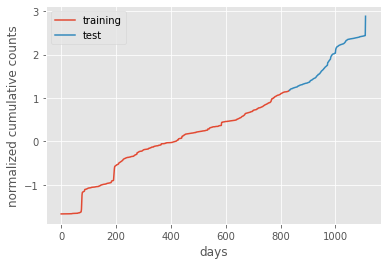

In [87]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    # train_test_split=0.8, normalize_data=True # try train_test_split=0.75
    train_test_split=0.75, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

### Model Architecture

In [88]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [89]:
input_dim = train_dset.X.shape[1]
num_levels = 2 # number of levels in the scinet tree
kernel_size = 4 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
n_epoch = 64 # number of epochs

# Choose your loss function!
# criterion = nn.MSELoss() # L2 loss
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

### Run Training

In [90]:

from tqdm.notebook import tqdm

In [91]:
torch.manual_seed(0) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# print Huber Loss
test_loss_vals

[0.03661757506779395,
 0.01847128388180863,
 0.016147930102306418,
 0.014826534927124158,
 0.004818539406187483,
 0.0019136777646053815,
 0.0016505686107848305,
 0.0013856653781658679,
 0.0011231540636345017,
 0.0011597513986316699,
 0.0011595447620038613,
 0.0010914931762044944,
 0.001041590888689825,
 0.0010920563800027594,
 0.001104485711948655,
 0.0010635226475415038,
 0.0011005680369180482,
 0.0011370352190169797,
 0.0010163381411985029,
 0.001041790850877078,
 0.0010762595923097251,
 0.0011141942241010838,
 0.001080780649317603,
 0.001030318091807203,
 0.0010938806121885136,
 0.0011536561796674505,
 0.0011262088669354853,
 0.001118560711347527,
 0.0011336837787894183,
 0.0011017774322681362,
 0.001058309005202318,
 0.000999263965695718,
 0.0009697402356323437,
 0.0009306657379966055,
 0.0008424589054811804,
 0.0008819330805636127,
 0.0009252008558178204,
 0.0009068293052223453,
 0.0009312114466411003,
 0.0009269273568861536,
 0.000915465272100846,
 0.0008608979892414936,
 0.00077

Text(0.5, 0, 'Epoch')

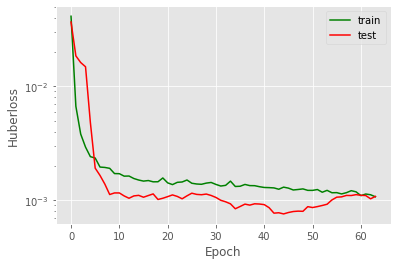

In [20]:
plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.legend()
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')

Visualize the forecast

## Trying out new prediction routine 

In [70]:
start_input = 700
end_input = start_input + input_len
end_output = end_input + horizon

sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]


In [71]:
model.train()
model.bn1.training=False
model.bn2.training=False

start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon



In [72]:
sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]
input_y


tensor([1.1788, 1.1839, 1.1931, 1.1998, 1.2040, 1.2074, 1.2124, 1.2124, 1.2158,
        1.2166, 1.2166, 1.2175, 1.2259, 1.2301, 1.2309, 1.2309, 1.2317, 1.2351,
        1.2393, 1.2418, 1.2427, 1.2443, 1.2452, 1.2494, 1.2510, 1.2510, 1.2519,
        1.2527, 1.2578, 1.2636, 1.2720, 1.2746, 1.2762])

In [73]:
samples = []
outputs_y = []
sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]
for i in range(2):
    outputs_y.append(output_y)
    _predict = model(sample_x[None,:,:])
    samples.append(_predict.data.squeeze()) # output?
    start_input = start_input + horizon
    end_input = end_input + horizon
    end_output = end_input + horizon
    sample_x = test_dset.X[start_input:end_input]
    sample_x[None,-horizon:,-1] = _predict.data.squeeze() # replacing last seismic data with the prediction
    output_y = test_dset.Y[end_input:end_output]
    model.eval()



In [74]:
sample_x

tensor([[0.1675, 0.3282, 1.3014],
        [0.1767, 0.3177, 1.3048],
        [0.1858, 0.3072, 1.3056],
        [0.1950, 0.2967, 1.3056],
        [0.2042, 0.2863, 1.3072],
        [0.2134, 0.2758, 1.3074],
        [0.2226, 0.2653, 1.3233],
        [0.2318, 0.2548, 1.3243],
        [0.2409, 0.2443, 1.3259],
        [0.2501, 0.2339, 1.3274],
        [0.2593, 0.2234, 1.3290],
        [0.2685, 0.2129, 1.3340],
        [0.2777, 0.2024, 1.3401],
        [0.2869, 0.1920, 1.3416],
        [0.2960, 0.1815, 1.3432],
        [0.3052, 0.1710, 1.3443],
        [0.3144, 0.1605, 1.3459],
        [0.3236, 0.1500, 1.3487],
        [0.3328, 0.1396, 1.3502],
        [0.3419, 0.1291, 1.3502],
        [0.3511, 0.1186, 1.3524],
        [0.3606, 0.1083, 1.3539],
        [0.3733, 0.1003, 1.3555],
        [0.3860, 0.0922, 1.3596],
        [0.3986, 0.0841, 1.3611],
        [0.4113, 0.0760, 1.3616],
        [0.4240, 0.0679, 1.3622],
        [0.4366, 0.0598, 1.3637],
        [0.4493, 0.0517, 1.3653],
        [0.462

In [75]:
torch.cat(samples).squeeze().squeeze()

tensor([1.3072, 1.3074, 1.3233, 1.3243, 1.3259, 1.3274, 1.3290, 1.3340, 1.3401,
        1.3416, 1.3432, 1.3443, 1.3459, 1.3487, 1.3502, 1.3502, 1.3524, 1.3539,
        1.3555, 1.3596, 1.3611, 1.3616, 1.3622, 1.3637, 1.3653, 1.3681, 1.3711,
        1.3729])

In [76]:
torch.cat(outputs_y)

tensor([1.2762, 1.2771, 1.2779, 1.2872, 1.2888, 1.2922, 1.2930, 1.2964, 1.2989,
        1.2989, 1.3014, 1.3048, 1.3056, 1.3056, 1.3065, 1.3115, 1.3157, 1.3182,
        1.3207, 1.3233, 1.3258, 1.3283, 1.3291, 1.3300, 1.3342, 1.3359, 1.3367,
        1.3384])

In [77]:
torch.cat(samples)

tensor([1.3072, 1.3074, 1.3233, 1.3243, 1.3259, 1.3274, 1.3290, 1.3340, 1.3401,
        1.3416, 1.3432, 1.3443, 1.3459, 1.3487, 1.3502, 1.3502, 1.3524, 1.3539,
        1.3555, 1.3596, 1.3611, 1.3616, 1.3622, 1.3637, 1.3653, 1.3681, 1.3711,
        1.3729])

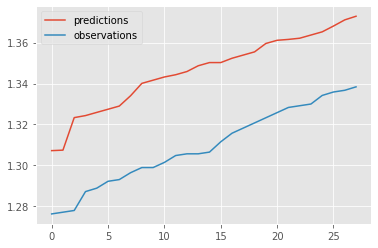

In [78]:
plt.plot(torch.cat(samples),label='predictions')
plt.plot(torch.cat(outputs_y),label='observations')
plt.legend()